# Landsat-8 Built Up Index Time Series via Sentinel-Hub Process API

### _Import functional dependencies and add repository source directory to system path_

In [1]:
import os
import yaml
from munch import munchify

In [2]:
# define repo name and get root working directory
repo = 'sentinelhub'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\Chris.Williams\\Documents\\GitHub\\sentinelhub'

In [3]:
# add repo source + notebooks directory to system path
import sys
sys.path.insert(0, os.path.join( root_path, 'src' ) )
sys.path.insert(0, os.path.join( root_path, 'notebooks' ) )

In [4]:
# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'landsat-8' )
cfg_path

'C:\\Users\\Chris.Williams\\Documents\\GitHub\\sentinelhub\\cfg\\landsat-8'

### _Load configuration file from repository cfg sub-directory_ 

In [5]:
# get pathname to configuration file
cfg_file = os.path.join( cfg_path, 'l8-timeseries-bui.yml' )

In [6]:
# print contents of configuration file
with open( cfg_file ) as f:
    print ( f.read() )

request:
    collection: LANDSAT8_L2
    evalscript: |
                //VERSION=3
                function setup() {
                    return {
                        input: [{
                            bands: ["B04", "B05", "B06"],
                            units: ["reflectance", "reflectance", "reflectance"] 
                        }],
                        output: {
                            bands: 1,
                            sampleType: "FLOAT32"
                        }
                    };
                }
                function evaluatePixel(sample) {
                    let ndvi = ( sample.B05 - sample.B04) / ( sample.B05 + sample.B04 );
                    let ndbi = ( sample.B06 - sample.B05) / ( sample.B06 + sample.B05 );
                    let BU = (ndvi - ndbi)
                    return[ BU ];                
                }
responses:
    default: TIFF
aoi:
    pathname: <path-to-aoi-file>
    name: name
    distance: 500



In [7]:
# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

### _Define area of interest collated with the city of Nagpur, India_

In [8]:
# define min and max latlons
coords = 78.943909,21.046800,79.193848,21.240746
resolution = 20

In [9]:
# create instance of shclient class
from client import ShClient
client = ShClient( config )

In [10]:
# get utm bbox
bbox = client.getBoundingBox( coords )
print ( bbox, bbox.crs.value )

286345.321104591,2328704.2948572394,312568.36171182257,2349862.5627038986 32644


In [11]:
# get aoi image dimensions
client.getBoxDimensions( bbox, resolution )

(1311, 1058)

### _Use Catalog API to locate available L8 scenes acquired early March 2021_

In [12]:
# define aggregation timeframe
from datetime import datetime
timeframe = { 'start' : datetime.strptime('2021-03-01', '%Y-%m-%d'), 'end' : datetime.strptime('2021-03-10', '%Y-%m-%d') }

In [13]:
# get scenes from catalogue
client.getTimeStamps( bbox, timeframe )

[datetime.datetime(2021, 3, 2, 5, 8, 27, 582000, tzinfo=tzutc())]

### _Download and visualise L8 Built-up Index Images via Process API client_

In [14]:
# get mosaic between timeframe at specified pixel resolution
response = client.getTimeSeries( bbox, timeframe, resolution )
response._df

,default,time
0,"[[0.7145596, 0.5869518, 0.5469976, 0.5469976, ...",2021-03-02 05:08:27.582000+00:00


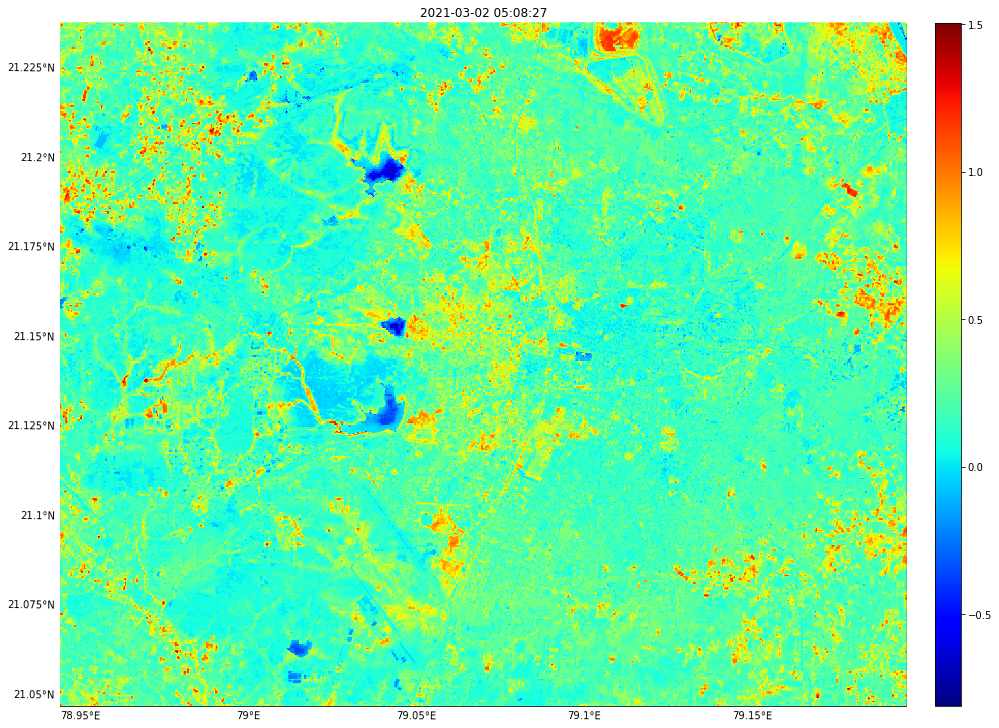

In [15]:
response.plotColorMesh( 'default', alpha={ 'data': 1.0, 'grid' : 0.1 } )

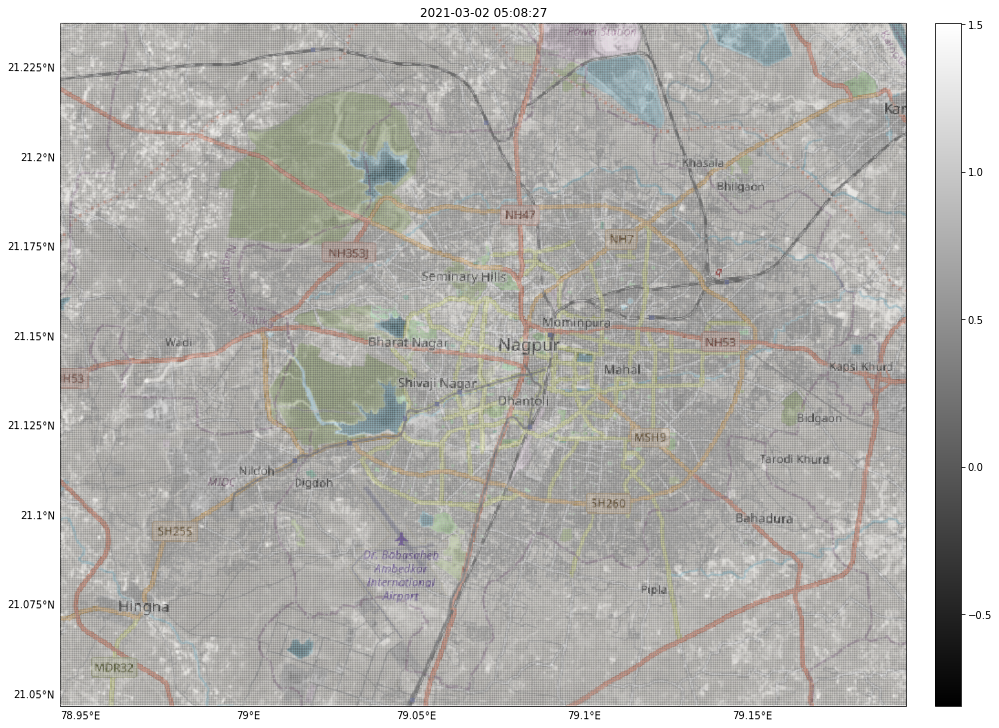

In [16]:
response.plotColorMesh( 'default', osm_zoom=12, alpha={ 'data': 0.10, 'grid' : 0.0 }, cmap='gray' )